# 2024 YR4

[2024 YR4](https://en.wikipedia.org/wiki/2024_YR4) is a near-Earth asteroid between 40 and 100 metres in diameter.
It was discovered by the Chilean station of the Asteroid Terrestrial-impact Last Alert System (ATLAS) on 27 December 2024.
The NASA JPL Center for NEO Studies and ESA Near-Earth Objects Coordination Centre (NEOCC) estimates that there is a 1.3% chance that this asteroid will impact Earth in 2032. For more details, see [this warning](https://iawn.net/documents/NOTIFICATIONS/IAWN_Potential_Impact_Notification_2024_YR4.pdf) issued by the [International Asteroid Warning Network (IAWN)](https://iawn.net).

This notebook illustrates how to use [REBOUND](https://github.com/hannorein/rebound) to obtain the current orbital parameters for 2024 YR4 from [NASA Horizons](). Then, [ASSIST](https://github.com/matthewholman/assist) is used to integrate the orbit forward in time. **Note:** This notebook should not be used to assess the impact probability of this asteroid. It merely illustrates the capabilities of REBOUND and ASSIST.

This notebook assumes that you already have REBOUND and ASSIST installed. Details on how to do that are described in the documentation of [REBOUND](https://rebound.readthedocs.io/en/latest/) and [ASSIST](https://assist.readthedocs.io/en/latest/). You will also need numpy and matplotlib to run this example. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs   # for maps
import rebound
import assist
import datetime

from astropy import units as u
from astropy.coordinates import SkyCoord  # for coordinate conversion

We begin the integration at midnight (UTC) on Feburary 2nd 2025 which corresponds to the following Julian date.

In [2]:
date_initial = datetime.datetime(2025, 2, 2, tzinfo=datetime.timezone.utc)
jd_initial = 2460708.5

Let us create a new REBOUND simulation and attach ASSIST to it.

In [ ]:
sim = rebound.Simulation()
ephem = assist.Ephem("../data/linux_p1550p2650.440", "../data/sb441-n16.bsp")
extras = assist.Extras(sim, ephem)
extras.gr_eih_sources = 11 # Turn on general relativistic corrections for all bodies
sim.t = jd_initial - ephem.jd_ref # Code units will be Julian days relative to jd_ref

We use the improved timestepping mode by [Pham et al. (2024)](https://arxiv.org/abs/2401.02849) for the IAS15 integrator. This method provides better adaptive timesteps when resolving very close encounters.

In [5]:
sim.ri_ias15.adaptive_mode = 2 # Pham et al. (2024)

Next, we obtain the latest orbital parameters for 2024 YR4 from NASA's Horizons system. Note that in order to be consistent with the coordinate system used by ASSIST, we set the plane parameter to *frame*, which corresponds to the equatorial inertial frame. You can safely ignore the warning message about the mass being zero.

In [6]:
sim.add("2024 YR4",plane="frame", date="JD%f"%jd_initial)

Searching NASA Horizons for '2024 YR4'... 
Found: (2024 YR4) 


/home/lo/Documents/src/asteroid/.venv/lib/python3.12/site-packages/rebound/horizons.py:172: RuntimeWarning: Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.
  warnings.warn("Warning: Mass cannot be retrieved from NASA HORIZONS. Set to 0.", RuntimeWarning)


We now integrate the orbit 9 years into the future and keep track of the positions of the asteroid and the Earth. 

In [7]:
times = np.linspace(sim.t, sim.t + 365.25 * 9, 100000)
asteroid_pos = np.zeros((len(times), 3))
earth_pos = np.zeros((len(times), 3))
for i, t in enumerate(times):
    extras.integrate_or_interpolate(t)
    asteroid_pos[i] = sim.particles[0].xyz
    earth_pos[i] = ephem.get_particle("earth", t).xyz

We can now plot the orbit of the asteroid and the Earth. One can easily see that the orbits are crossing and that the asteroid's orbit was significantly perturbed during its last close encounter with Earth. 

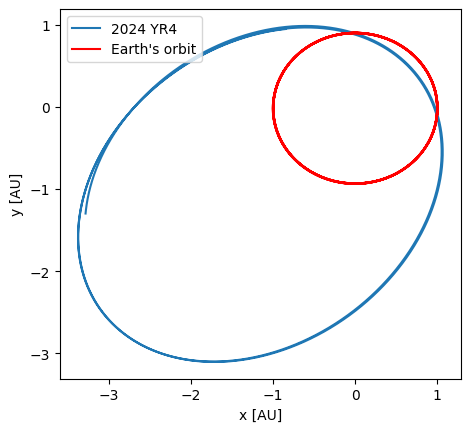

In [8]:
fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlabel("x [AU]"); ax.set_ylabel("y [AU]")
ax.plot(asteroid_pos[:,0],asteroid_pos[:,1], label="2024 YR4")
ax.plot(earth_pos[:,0],earth_pos[:,1], color="r", label="Earth's orbit")
ax.legend();

Let us zoom in on the close encounter by moving to a frame that is co-moving with Earth. The size of the Earth and the orbit of the Moon are shown to scale.

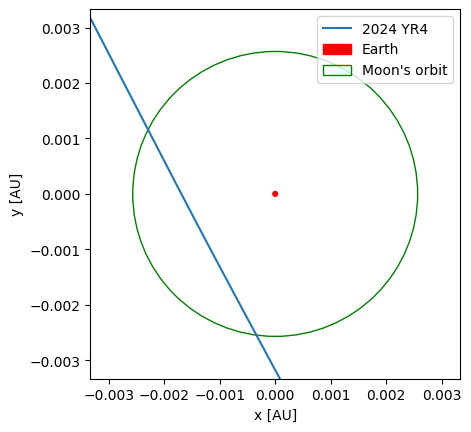

In [9]:
earth_radius = 4.2587571e-05 # in AU
moon_distance = 0.0025695553 # in AU
zoom = 3e2

fig, ax = plt.subplots()
ax.set_aspect("equal")
ax.set_xlabel("x [AU]"); ax.set_ylabel("y [AU]")
ax.set_xlim([-1/zoom,1/zoom]); ax.set_ylim([-1/zoom,1/zoom])
ax.plot(asteroid_pos[:,0]-earth_pos[:,0],asteroid_pos[:,1]-earth_pos[:,1], label="2024 YR4")
ax.add_patch(plt.Circle((0,0), earth_radius, color="r", label="Earth"))
ax.add_patch(plt.Circle((0,0), moon_distance, color="g", fill=False, label="Moon's orbit"))
ax.legend();

We can also plot the distance as a function of time.

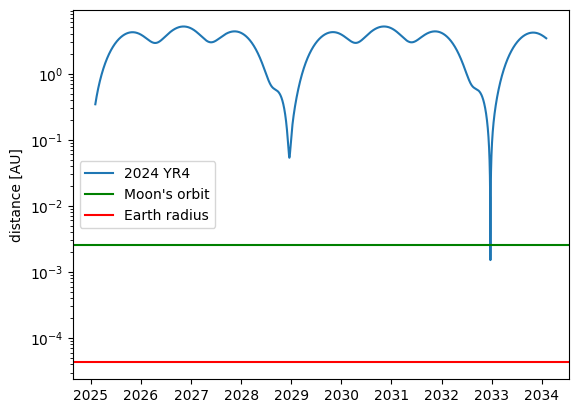

In [10]:
# Convert from code units (days relative to jd_ref) to a python datetime object
x = [date_initial + datetime.timedelta(days=(t-times[0])) for t in times]

fig, ax = plt.subplots()
ax.set_yscale("log")
ax.set_ylabel("distance [AU]")
ax.plot(x, np.linalg.norm(asteroid_pos-earth_pos, axis=1), label="2024 YR4")
ax.axhline(y=moon_distance, color='g', label="Moon's orbit")
ax.axhline(y=earth_radius, color='r', label="Earth radius")
ax.legend();

Finally, let us caltulate the time of closest approach, which will be on December 22nd 2032.

In [11]:
ix = np.argmin(np.linalg.norm(asteroid_pos-earth_pos, axis=1))
print(x[ix].strftime("%Y-%m-%d %H:%M (UTC)"))

2032-12-22 09:11 (UTC)


Plot the nearest points on earth +-10 time steps from closest approach to earth.

/home/lo/Documents/src/asteroid/.venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "dtf2d" yielded 1 of "dubious year (Note 6)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/lo/Documents/src/asteroid/.venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "d2dtf" yielded 1 of "dubious year (Note 5)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/lo/Documents/src/asteroid/.venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utctai" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/lo/Documents/src/asteroid/.venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA function "utcut1" yielded 1 of "dubious year (Note 3)"
  warn(f'ERFA function "{func_name}" yielded {wmsg}', ErfaWarning)
/home/lo/Documents/src/asteroid/.venv/lib/python3.12/site-packages/erfa/core.py:133: ErfaWarning: ERFA

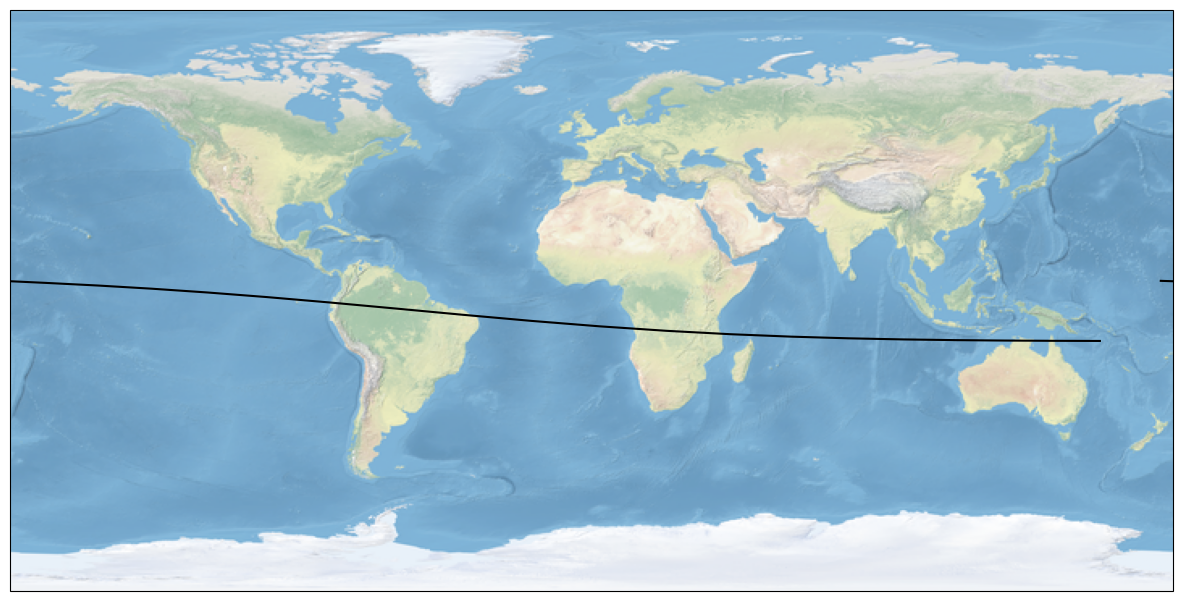

In [12]:

interval = 10
a = ix - interval
b = ix + interval

converted_coordinates = []
for i in range(a,b):
    converted_coordinates += [SkyCoord(*asteroid_pos[i,:],frame='icrs', representation_type='cartesian', unit='au', obstime=x[i]).itrs.spherical]


lons =[x.lon.degree for x in converted_coordinates]
lats = [x.lat.degree for x in converted_coordinates]

plt.figure(figsize=(15, 25))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.stock_img()

plt.plot(lons, lats, 'k',
         transform=ccrs.Geodetic());